# Building a GPT Language Model from Scratch

This notebook contains code for building a GPT language model from scratch following the tutorial videos at [this link](https://www.youtube.com/watch?v=yAcWnfsZhzo)

In [1]:
import os
import re
import json
import urllib
import time
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tiktoken

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf

import numpy as np

2025-12-04 18:24:43.475321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764872683.823678      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764872683.938277      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.2,
    "qvk_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

MODEL_CHOSEN = "gpt2-medium (355M)"
# MODEL_CHOSEN = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[MODEL_CHOSEN])

model_size = MODEL_CHOSEN.split(" ")[-1].lstrip("(").rstrip(")")

In [3]:
# file_path = "/kaggle/input/house-plant-instruction-dataset/houseplant_instruction_dataset.json"
file_path = "/kaggle/input/gardening-q-and-a/dataset_plants_v5.jsonl"
test_file_path = "/kaggle/input/ai-gardenwise-test-dataset/GardenWise_test_dataset_6.jsonl"

INPUT_FIELD = "context"
RESPONSE_FIELD = "response"

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Attention

In [6]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
      super().__init__()
      assert (d_out % num_heads == 0), \
          "d_out must be divisible by num_heads"

      self.d_out = d_out
      self.num_heads = num_heads
      self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

      self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
      self.dropout = nn.Dropout(dropout)
      self.register_buffer(
          "mask",
          torch.triu(torch.ones(context_length, context_length),
                      diagonal=1)
      )

  def forward(self, x):
      b, num_tokens, d_in = x.shape
      # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`,
      # this will result in errors in the mask creation further below.
      # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
      # do not exceed `context_length` before reaching this forward method.

      keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
      queries = self.W_query(x)
      values = self.W_value(x)

      # We implicitly split the matrix by adding a `num_heads` dimension
      # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
      keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
      values = values.view(b, num_tokens, self.num_heads, self.head_dim)
      queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

      # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
      keys = keys.transpose(1, 2)
      queries = queries.transpose(1, 2)
      values = values.transpose(1, 2)

      # Compute scaled dot-product attention (aka self-attention) with a causal mask
      attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

      # Original mask truncated to the number of tokens and converted to boolean
      mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

      # Use the mask to fill attention scores
      attn_scores.masked_fill_(mask_bool, -torch.inf)

      attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
      attn_weights = self.dropout(attn_weights)

      # Shape: (b, num_tokens, num_heads, head_dim)
      context_vec = (attn_weights @ values).transpose(1, 2)

      # Combine heads, where self.d_out = self.num_heads * self.head_dim
      context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
      context_vec = self.out_proj(context_vec) # optional projection

      return context_vec

## GELU, LayerNorm and FeedForward

In [7]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

## Transformer

In [8]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qvk_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

## Model

In [9]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

## Generating text

In [10]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, top_pos = torch.topk(logits, k=top_k)
      new_logits = torch.where(
          condition = logits < top_logits[:, -1],
          input = torch.tensor(float("-inf")),
          other = logits
      )
      logits = new_logits

    if temperature > 0.0:
      probs = torch.softmax(logits / temperature, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.argmax(probs, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [11]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  return torch.tensor(encoded).unsqueeze(0)

def token_ids_to_text(token_ids, tokenizer):
  return tokenizer.decode(token_ids.squeeze(0).tolist())

## Load weights from OpenAI

In [12]:
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

In [13]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## Fine tuning to follow instructions
Supervised instruction finetuning

In [14]:
def download_and_load_file(file_path, url=None):
  data = []
  with open(file_path, "r", encoding="utf-8") as f:
      for line in f:
          data.append(json.loads(line))

  return data

data = download_and_load_file(file_path)
test_data = download_and_load_file(test_file_path)

print("Number of entries: ", len(data))
print("Number of test entries: ", len(test_data))

Number of entries:  939
Number of test entries:  30


In [15]:
def format_input(entry, field_name=INPUT_FIELD):
  instruction_text = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request.\n\n"
      f"### Instruction:\n{entry['instruction']}"
  )

  
  value = entry.get(field_name)
  input_text = f"\n\n### Context:\n{value}" if value is not None else ""


  return instruction_text + input_text

In [16]:
split = int(len(data) * 0.9)

train_data = data[:split]
val_data  = data[split:]
test_data = test_data

In [17]:
print("Training set length: ", len(train_data))
print("Validation set length: ", len(val_data))
print("Test set length: ", len(test_data))

Training set length:  845
Validation set length:  94
Test set length:  30


## Dataset

In [18]:
class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    self.encoded_texts = []

    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry[RESPONSE_FIELD]}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

In [19]:
def custom_collate(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):

  batch_max_length = max(len(item) +1 for item in batch)

  inputs_list, targets_list = [], []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )

    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])

    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()

    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index

    inputs_list.append(inputs)
    targets_list.append(targets)

  inputs_tensor = torch.stack(inputs_list).to(device)
  targets_tensor = torch.stack(targets_list).to(device)
  return inputs_tensor, targets_tensor

## Dataloader

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
customized_collate_fn = partial(
    custom_collate,
    device=device,
    allowed_max_length=BASE_CONFIG["context_length"]
)

In [22]:
num_workers = 0
batch_size = 4

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## Loading pretrained weights

In [24]:
settings, params = download_and_load_gpt2(model_size, "gpt2")
print(f"Settings: {settings}")
print(f"Parameter dictionary keys: {params.keys()}")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 89.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 7.69MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 116kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:01<00:00, 23.2MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 15.0MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 6.00MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 3.42MiB/s]


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [25]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval();

## Loss

Perplexity is the exp of the loss

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

## Training

In [27]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text(
        model, encoded, max_new_tokens=50, context_size=context_size, temperature=1.4, top_k=25
    )
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

PATIENCE = 5
WARMUP_STEPS = 50

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Early Stopping Variables
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Learning Rate Scheduler setup (Simplified linear decay)
    max_steps = num_epochs * len(train_loader)
    initial_lr = optimizer.param_groups[0]['lr']

    for epoch in range(num_epochs):
        model.train()
        
        # Wrapping the train_loader with tqdm for visual progress bar
        # Add a description showing the current epoch and best validation loss
        train_loop = tqdm(
            train_loader, 
            desc=f"Epoch {epoch+1}/{num_epochs} | Val Loss: {best_val_loss:.4f}", 
            unit="batch"
        )

        for input_batch, target_batch in train_loop:
            
            # --- 1. Learning Rate Scheduling ---
            global_step += 1
            
            if global_step < WARMUP_STEPS:
                lr = initial_lr * (global_step / WARMUP_STEPS)
            else:
                progress = (global_step - WARMUP_STEPS) / (max_steps - WARMUP_STEPS)
                lr = initial_lr * max(0.0, 1.0 - progress)
                
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            # ----------------------------------

            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            # Add gradient clipping (Recommended best practice)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Update TQDM with current batch loss and LR
            train_loop.set_postfix(
                batch_loss=f"{loss.item():.4f}", 
                lr=f"{lr:.2e}"
            )

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                # --- 2. Early Stopping Check ---
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # Update TQDM description to reflect the new best validation loss
                train_loop.set_description(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {best_val_loss:.4f}")

                # Print detailed evaluation (outside tqdm loop)
                print("\n"
                      f"Epoch {epoch+1} (Step {global_step:06d}, LR: {lr:.2e}): "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Patience: {patience_counter}/{PATIENCE}"
                )

                if patience_counter >= PATIENCE:
                    print("Early stopping triggered: Validation loss not improving.")
                    return train_losses, val_losses, track_tokens_seen
                # ----------------------------------

        # Generate sample after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [28]:
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=100,
    eval_iter=None, start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) /60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1/10 | Val Loss: 3.4174:   0%|          | 1/211 [00:32<1:53:10, 32.34s/batch, batch_loss=4.1475, lr=0.00e+00]


Epoch 1 (Step 000000, LR: 0.00e+00): Train Loss: 3.4306, Val Loss: 3.4174, Patience: 0/5


Epoch 1/10 | Val Loss: 2.0911:  48%|████▊     | 101/211 [02:02<19:36, 10.69s/batch, batch_loss=1.7726, lr=1.95e-05]


Epoch 1 (Step 000100, LR: 1.95e-05): Train Loss: 1.5446, Val Loss: 2.0911, Patience: 0/5


Epoch 1/10 | Val Loss: 2.0666:  95%|█████████▌| 201/211 [03:36<01:56, 11.64s/batch, batch_loss=1.6505, lr=1.85e-05]


Epoch 1 (Step 000200, LR: 1.85e-05): Train Loss: 1.4366, Val Loss: 2.0666, Patience: 0/5


Epoch 1/10 | Val Loss: 2.0666: 100%|██████████| 211/211 [03:43<00:00,  1.06s/batch, batch_loss=1.7388, lr=1.84e-05]


Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Do You Need to Mix Your Compost?  ### Context: Compost can become clogged and difficult to remove after the winter.  ### Response: Yes and definitely! It usually needs more than an irrigation system for proper composting efficiency. It needs at least 3.5 inches per week for good


Epoch 2/10 | Val Loss: 2.0666:  43%|████▎     | 90/211 [01:35<24:31, 12.16s/batch, batch_loss=1.2701, lr=1.76e-05]


Epoch 2 (Step 000300, LR: 1.76e-05): Train Loss: 1.3626, Val Loss: 2.0792, Patience: 1/5


Epoch 2/10 | Val Loss: 2.0666:  90%|█████████ | 190/211 [03:17<04:18, 12.29s/batch, batch_loss=1.7165, lr=1.66e-05]


Epoch 2 (Step 000400, LR: 1.66e-05): Train Loss: 1.3004, Val Loss: 2.0788, Patience: 2/5


Epoch 2/10 | Val Loss: 2.0666: 100%|██████████| 211/211 [03:30<00:00,  1.00batch/s, batch_loss=1.8290, lr=1.64e-05]


Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Do You Need to Mix Your Compost?  ### Context: It is important that you check the nutrients each compost pile offers and if there are gaps in your home's compost pile.  ### Response: Potato manure compost is one of the most commonly used manure types. It should not be disturbed too


Epoch 3/10 | Val Loss: 2.0666:  37%|███▋      | 79/211 [01:29<27:06, 12.32s/batch, batch_loss=1.3841, lr=1.56e-05]


Epoch 3 (Step 000500, LR: 1.56e-05): Train Loss: 1.2508, Val Loss: 2.1030, Patience: 3/5


Epoch 3/10 | Val Loss: 2.0666:  85%|████████▍ | 179/211 [03:10<06:31, 12.24s/batch, batch_loss=1.3312, lr=1.47e-05]


Epoch 3 (Step 000600, LR: 1.47e-05): Train Loss: 1.1986, Val Loss: 2.1046, Patience: 4/5


Epoch 3/10 | Val Loss: 2.0666: 100%|██████████| 211/211 [03:29<00:00,  1.01batch/s, batch_loss=1.4048, lr=1.43e-05]


Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Do You Need to Mix Your Compost?  ### Context: Compost often is not compostable.  ### Response: Mixing with organic matter is important if your home has multiple composting areas or you are adding compost to the soil as often as twice per season, as there will be a


Epoch 4/10 | Val Loss: 2.0666:  32%|███▏      | 67/211 [01:21<02:56,  1.22s/batch, batch_loss=1.4359, lr=1.37e-05]


Epoch 4 (Step 000700, LR: 1.37e-05): Train Loss: 1.1665, Val Loss: 2.1151, Patience: 5/5
Early stopping triggered: Validation loss not improving.
Training completed in 12.27 minutes.


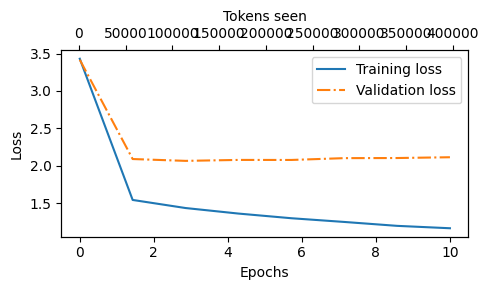

In [29]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss_plot.png")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [30]:
model.eval()

input = format_input(
    {
        "instruction":"How often should I have to water my rubber plant?",
        INPUT_FIELD:"It's a rainy day and the plant is placed outside"
    }
)
encoded = text_to_token_ids(input, tokenizer).to(device)

idxs = generate_text(model, encoded, max_new_tokens=100, eos_id=50256, context_size=BASE_CONFIG["context_length"])

response = token_ids_to_text(idxs, tokenizer)
print(response)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
How often should I have to water my rubber plant?

### Context:
It's a rainy day and the plant is placed outside.

### Response:
Water the plant every two to three days. If the soil is dry, water it every two to three days. If the soil is wet, water it every two to three days.


## Extracting and saving responses

In [31]:
for entry in test_data[:3]:
  input_text = format_input(entry)

  token_ids = generate_text(
      model=model,
      idx=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256
  )

  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = (
      generated_text[len(input_text):]
      .split("### Response:")[1]
      .strip()
  )

  print(input_text)
  print(f"\nCorrect response:\n>> {entry[RESPONSE_FIELD]}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are the easiest vegetables to grow at home?

Correct response:
>> Lettuce, radishes, green beans, and cherry tomatoes are easy vegetables to grow at home. They need minimal care, sunlight, and regular watering, making them great for beginners and small spaces.

Model response:
>> The easiest vegetables to grow at home are lettuce, spinach, and tomatoes. These vegetables are easy to grow indoors and can be grown year-round.
------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
How often should I water mybgarden?

Correct response:
>> Water your garden once or twice a week, allowing the soil to dry slightly between waterings.

Model response:
>> Water yourbgarden every two to three weeks. Regular watering helps prevent soil compaction and helps preve

In [32]:
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate_text(
      model=model,
      idx=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].split("### Response:")[1].strip()

    test_data[i]["model_response"] = response_text

with open("gardening-q-and-a-test-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 30/30 [01:23<00:00,  2.80s/it]


 ## Save model

SFT = Supervised FineTuning

In [33]:
prefix = f"{re.sub(r'[ ()]', '', MODEL_CHOSEN)}-sft"
file_name = f"{prefix}.pth"
file_name_onnx = f"{prefix}.onnx"

In [34]:
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [35]:
from IPython.display import FileLink
FileLink(file_name)

/kaggle/working/gpt2-medium355M-sft.pth

## Model conversion

In [36]:
input_text = format_input(test_data[0])
dummy_input = text_to_token_ids(input_text, tokenizer).to(device)

torch.onnx.export(
    model,
    dummy_input,
    file_name_onnx,
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

print(f"Exported to {file_name_onnx}")

/tmp/ipykernel_20/956050387.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.sqrt(torch.tensor(2.0 / torch.pi)) *


Exported to gpt2-medium355M-sft.onnx


In [37]:
FileLink(file_name_onnx)

/kaggle/working/gpt2-medium355M-sft.onnx